# Modelo RNN Con Memoria (LSTM)

En este cuaderno se implementa una Red Neuronal Recurrente con memoria a largo plazo (LSTM) para la clasificación de texto.
Las redes LSTM están diseñadas para evitar el problema del desvanecimiento del gradiente y capturar dependencias a largo plazo en secuencias.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score

# Configuración del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


## Carga y Preprocesamiento de Datos

Se cargan los archivos `.npy` y se preparan los tensores.
Al igual que en el modelo simple, redimensionamos la entrada a `(N, 1, 384)`.

In [2]:
# Cargar datos
train_X = np.load('train_all.npy')
train_y = np.load('train_labels.npy')
valid_X = np.load('valid_all.npy')
valid_y = np.load('valid_labels.npy')
test_X = np.load('test_all.npy')
test_y = np.load('test_labels.npy')

# Convertir a tensores y redimensionar
X_train_tensor = torch.tensor(train_X, dtype=torch.float32).unsqueeze(1).to(device)
y_train_tensor = torch.tensor(train_y - 1, dtype=torch.long).to(device)

X_valid_tensor = torch.tensor(valid_X, dtype=torch.float32).unsqueeze(1).to(device)
y_valid_tensor = torch.tensor(valid_y - 1, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(test_X, dtype=torch.float32).unsqueeze(1).to(device)
y_test_tensor = torch.tensor(test_y - 1, dtype=torch.long).to(device)

# DataLoaders
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")

Train samples: 1200000


## Definición del Modelo LSTM

Se utiliza `nn.LSTM` en lugar de `nn.RNN`.
- **Input Size**: 384.
- **Hidden Size**: 128.
- **Output Size**: 5.

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        # out shape: (batch, seq_len, hidden_size)
        # h_n, c_n shapes: (num_layers, batch, hidden_size)
        out, (h_n, c_n) = self.lstm(x)
        
        # Tomamos la salida del último paso de tiempo
        last_out = out[:, -1, :]
        
        out = self.fc(last_out)
        return out

# Instanciar el modelo
input_size = 384
hidden_size = 128
output_size = 5
model = LSTMModel(input_size, hidden_size, output_size).to(device)
print(model)

LSTMModel(
  (lstm): LSTM(384, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)


## Entrenamiento

Entrenamiento del modelo LSTM con `CrossEntropyLoss` y `Adam`.

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
        
    train_acc = 100 * correct_train / total_train
    avg_train_loss = train_loss / len(train_loader)
    
    # Validación
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += y_batch.size(0)
            correct_valid += (predicted == y_batch).sum().item()
            
    valid_acc = 100 * correct_valid / total_valid
    avg_valid_loss = valid_loss / len(valid_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

Epoch [1/10], Train Loss: 1.0904, Train Acc: 52.02%, Valid Loss: 1.0654, Valid Acc: 53.35%
Epoch [2/10], Train Loss: 1.0569, Train Acc: 53.48%, Valid Loss: 1.0549, Valid Acc: 53.47%
Epoch [3/10], Train Loss: 1.0444, Train Acc: 54.04%, Valid Loss: 1.0499, Valid Acc: 53.77%
Epoch [4/10], Train Loss: 1.0357, Train Acc: 54.48%, Valid Loss: 1.0467, Valid Acc: 54.11%
Epoch [5/10], Train Loss: 1.0289, Train Acc: 54.75%, Valid Loss: 1.0461, Valid Acc: 54.08%
Epoch [6/10], Train Loss: 1.0232, Train Acc: 55.08%, Valid Loss: 1.0469, Valid Acc: 54.26%
Epoch [7/10], Train Loss: 1.0185, Train Acc: 55.26%, Valid Loss: 1.0474, Valid Acc: 54.09%
Epoch [8/10], Train Loss: 1.0143, Train Acc: 55.49%, Valid Loss: 1.0479, Valid Acc: 54.14%
Epoch [9/10], Train Loss: 1.0106, Train Acc: 55.63%, Valid Loss: 1.0483, Valid Acc: 54.31%
Epoch [10/10], Train Loss: 1.0074, Train Acc: 55.78%, Valid Loss: 1.0488, Valid Acc: 54.10%


## Evaluación

Evaluación del modelo LSTM en el conjunto de prueba.

In [5]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5']))

Test Accuracy: 53.74%

Classification Report:
              precision    recall  f1-score   support

     Clase 1       0.64      0.68      0.66      6000
     Clase 2       0.45      0.47      0.46      6000
     Clase 3       0.44      0.39      0.41      6000
     Clase 4       0.47      0.44      0.45      6000
     Clase 5       0.66      0.71      0.68      6000

    accuracy                           0.54     30000
   macro avg       0.53      0.54      0.53     30000
weighted avg       0.53      0.54      0.53     30000



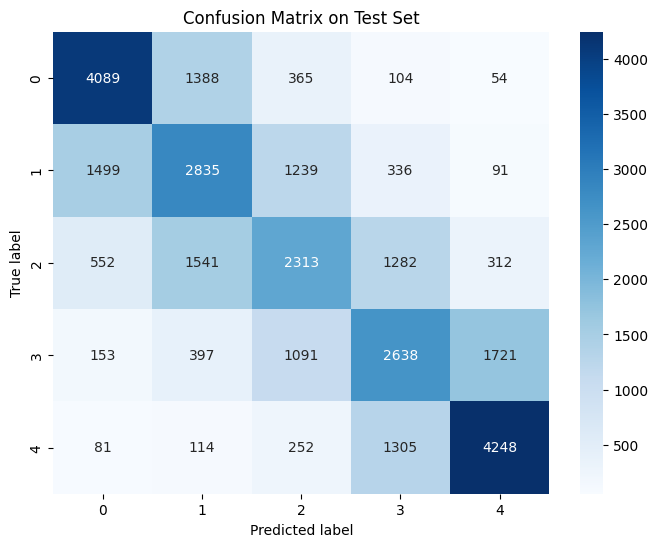

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
